In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [2]:
torch.backends.mps.enabled = True
torch.backends.mps.random_seed = 12345

# Set the PyTorch backend to Metal
pl.utilities.XLA_AVAILABLE = False
pl.utilities.DEVICE = "mps"


In [49]:
class CNNModel(pl.LightningModule):
    def __init__(self, in_channels=4, num_classes=3):
        super(CNNModel, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # nn.Conv2d(512, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(256, 128, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        shape = x.shape
        # print("input x.shape: ", x.shape)
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=shape[-2:], mode='bilinear', align_corners=True)

        # print("output x.shape: ", x.shape)


        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        # print("y_hat.shape: ", y_hat.shape)
        # print("y.shape: ", y.shape)
        # print("x.shape: ", x.shape)

        y = y.view(-1, *x.shape[-2:])

        loss = F.cross_entropy(y_hat, y.long())

        # loss= DiceLoss(mode = 'multiclass')(y_hat, y)   # Ypred = NxCxHxW Ytrue NxHxW
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        # print("y_hat.shape: ", y_hat.shape)
        # print("y.shape: ", y.shape)
        # print("x.shape: ", x.shape)

        y = y.view(-1, *x.shape[-2:])

        loss = F.cross_entropy(y_hat, y.long())

        # loss= DiceLoss(mode = 'multiclass')(y_hat, y)   # Ypred = NxCxHxW Ytrue NxHxW

        self.log('train_loss', loss)
        return loss


In [37]:
class classic_CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Input 4 x 357 x 717
        self.classes = 4
        self.features = 4 
        self.kernel_size = 3
        self.accuracy = torchmetrics.F1score(task = 'multiclass')
        # Encoder
        self.encoder = nn.Sequential( 
            nn.Conv2d(self.features, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 6))
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 6),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.classes, 3, stride=2, padding=1, output_padding=0))
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def loss_fn(self,ypred,ytrue):
        return DiceLoss(mode = 'multiclass', ignore_index = 999)(ypred, ytrue)   # Ypred = NxCxHxW Ytrue NxHxW
    
    def configure_optimizers(self):
        LR = 1e-4
        optimizer = torch.optim.Adam(self.parameters(),lr=LR)
        return optimizer
    def training_step(self,batch,batch_idx):
        x,y = batch[0],batch[1]
        out = self(x)
        out = nn.Softmax(-1)(out)
        loss = self.loss_fn(out,y)
        return {'train_loss': loss, 'log': tensorboard_logs}       
    def validation_step(self,batch,batch_idx):
        x,y = batch[0],batch[1]
        label = y
        out = self(x)
        out = nn.Softmax(-1)(out)
        loss = self.loss_fn(out,label)
        logits = torch.argmax(out,dim=1, keepdim=True)
        accu = self.accuracy(logits, label)        
        self.log('valid_loss', loss)
        self.log('train_acc_step', accu)
        return {'val_loss': loss, 'train_acc': accu}

In [50]:
from OSSE_DataLoader import get_xarray, get_data_loaders

OSSE_train, eddies_train, OSSE_test =  get_xarray()
train_dataloader, val_dataloader = get_data_loaders(8, OSSE_train, eddies_train, 0, 0)

# data_iter = iter(train_dataloader)

# features, labels = next(data_iter)


/Users/arthur/Dev/Hackathons/hackathon-sdd/OSSE_DataLoader.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_full[:idx_split, :, :, :], dtype=torch.float32)
/Users/arthur/Dev/Hackathons/hackathon-sdd/OSSE_DataLoader.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_full[:idx_split, :, :, :], dtype=torch.int64)
/Users/arthur/Dev/Hackathons/hackathon-sdd/OSSE_DataLoader.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_full[idx_split:, :, :, :], dtype=torch.fl

In [24]:
train_dataloader.__len__()

29

In [51]:
modelPro2 = CNNModel()

trainer = pl.Trainer(max_epochs=10, accelerator="mps", log_every_n_steps=5)
trainer.fit(modelPro2, train_dataloader, val_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 260 K 
1 | decoder | Sequential | 219 K 
---------------------------------------
479 K     Trainable params
0         Non-trainable params
479 K     Total params
1.919     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [38]:
trainer.current_epoch
trainer.__dict__

{'state': TrainerState(status=<TrainerStatus.INTERRUPTED: 'interrupted'>, fn=<TrainerFn.FITTING: 'fit'>, stage=<RunningStage.TRAINING: 'train'>, _fault_tolerant_mode=<_FaultTolerantMode.DISABLED: 'disabled'>),
 '_data_connector': <pytorch_lightning.trainer.connectors.data_connector.DataConnector at 0x346cbb430>,
 '_accelerator_connector': <pytorch_lightning.trainer.connectors.accelerator_connector.AcceleratorConnector at 0x346cbb910>,
 '_logger_connector': <pytorch_lightning.trainer.connectors.logger_connector.logger_connector.LoggerConnector at 0x346cbb520>,
 '_callback_connector': <pytorch_lightning.trainer.connectors.callback_connector.CallbackConnector at 0x346cbb550>,
 '_checkpoint_connector': <pytorch_lightning.trainer.connectors.checkpoint_connector.CheckpointConnector at 0x346cbb400>,
 '_terminate_gracefully': False,
 '_signal_connector': <pytorch_lightning.trainer.connectors.signal_connector.SignalConnector at 0x346cbb280>,
 'tuner': <pytorch_lightning.tuner.tuning.Tuner at 0x

torch.Size([8, 4, 357, 717])
torch.Size([8, 357, 717])
torch.Size([357, 717])


/opt/homebrew/Caskroom/miniforge/base/envs/hackathon-sdd/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


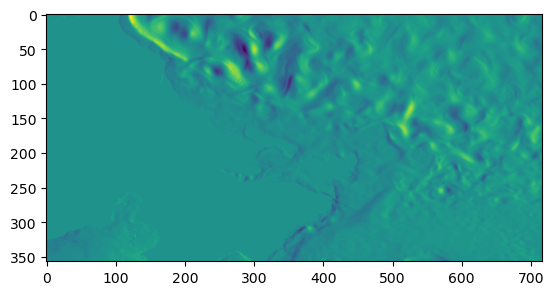

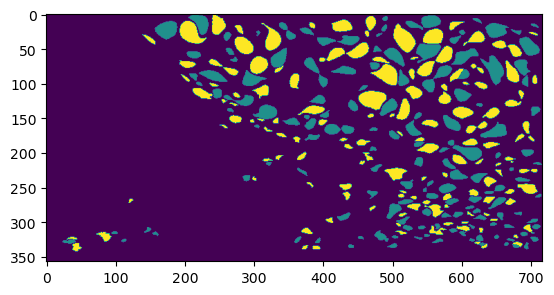

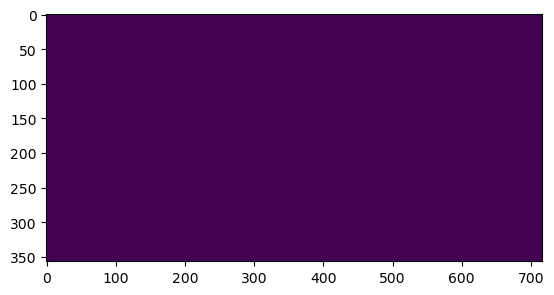

In [47]:
import matplotlib.pyplot as plt

# test on one sample
data_iter = iter(val_dataloader)

features, labels = next(data_iter)

DEVICE = "mps"

output = modelPro(features.to(DEVICE))

# soft max
output = torch.nn.functional.sigmoid(output)
print(output.shape)
# get predicted class
pred = torch.max(output, 1)[1]
print(pred.shape)
print(pred[1, :, :].shape)

# show the image of 1st sample
plt.imshow(features[1, 0, :, :].cpu().numpy())
plt.show()
# show the label of 1st sample
plt.imshow(labels[1, 0, :, :].cpu().numpy())
plt.show()
# show the predicted label of 1st sample
plt.imshow(pred[1, :, :].cpu().numpy())
plt.show()

In [44]:
# save model dict to file
torch.save(model.state_dict(), "./models/modelPro2.pt")

ReferenceError: weakly-referenced object no longer exists